## Project overview
Working as an analyst in the SaaS company, we need to regularly compare the product usage data for the previous two months to identify if there's an increase od decrease in client's product uasge.

As a result, I created an automatic data flow to extract product usage data from database as well as clean and add data on the Google Sheet used for looker studio through Google Sheets API, making sure that data is maintained only for the previous two months for comparison.

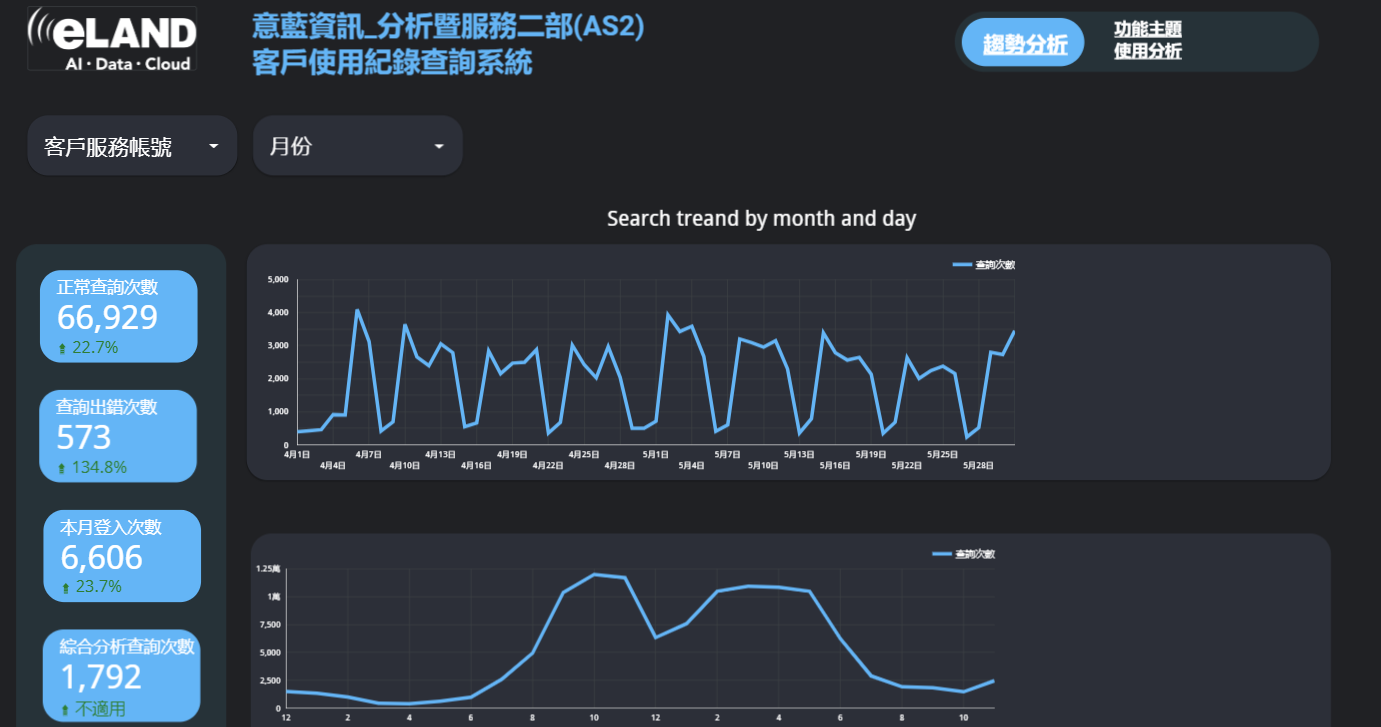

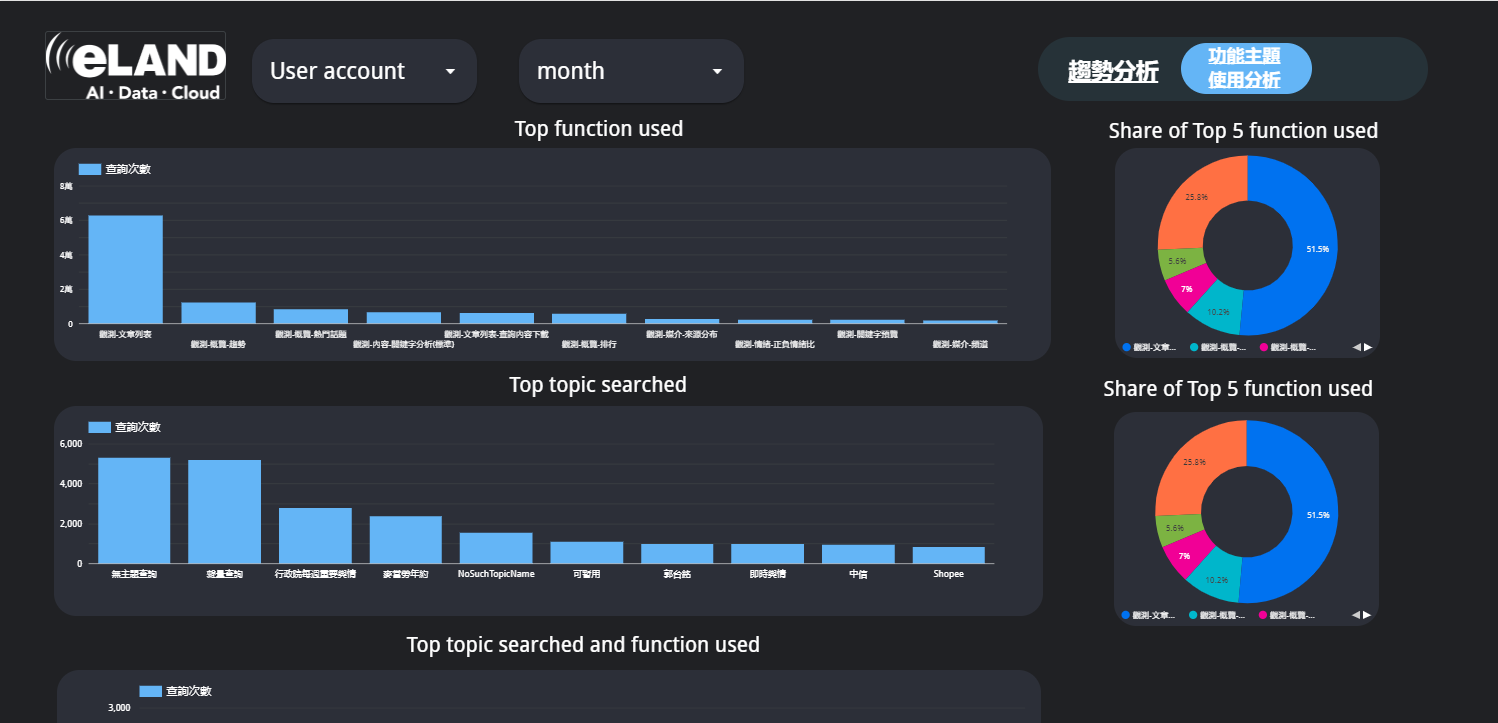

In [4]:
from google.oauth2.service_account import Credentials # 讀進專案週報的專案規劃
import gspread
import pyodbc                      # 讀進 DB 登入紀錄、使用紀錄
import numpy as np
import pandas as pd
import xlsxwriter
import datetime as dt
from dateutil.relativedelta import relativedelta
from pprint import pprint
from googleapiclient import discovery

##### 1. Since we want to build the dashboard that allows us to compare the performance between previous two months, we need to define the start date and the end date for data extraction from database. 

In [5]:
start_time_yearmonth = (dt.datetime.today() - relativedelta(months=2)).strftime('%Y-%m')
medium_time_yearmonth = (dt.datetime.today() - relativedelta(months=1)).strftime('%Y-%m') # 為了最後存檔方便
end_time_yearmonth = dt.datetime.today().strftime('%Y-%m') # this month
start_time = '%s-01' % start_time_yearmonth
end_time = '%s-01' % end_time_yearmonth

##### 2. Get the latest clients information from Google Sheet and filter out unwanted items.

In [6]:
##### 讀帳號資料
scope = ['https://www.googleapis.com/auth/spreadsheets']  # 定義存取範圍
creds = Credentials.from_service_account_file('client-monthly-usage-token.json', scopes=scope)  # 建立憑證物件，注意路徑
gs = gspread.authorize(creds)  # 進行驗證
sheet_url = 'https://docs.google.com/spreadsheets/d/1JpaEaUmgbE-iis_RieYTnn48kOMsSMri4AFbqnmwAEY/edit?usp=sharing'
sheet = gs.open_by_url(sheet_url)  # 開啟試算表
worksheet = sheet.worksheet('帳號清單')  # 開啟指定的工作表
guest_name_raw = pd.DataFrame(worksheet.get_all_records())
guest_name_raw

,#,服務階段,客編及簡稱,中文案名,PM,代理人,產業類型,服務項目,帳號
0,A21,03.末期,摘星,摘星_續_22,大豪/Dahao,婕昕/Jessie,EA代理商及市調研究,12.OPV標準進階平台,sowork
1,A23,03.末期,兆豐銀,兆豐銀_續_22,大豪/Dahao,閔文/Steven,KF金融及保險業,16.OPV資料匯送,megabk_2022
2,A24,03.末期,可樂,可樂_續_2023,大豪/Dahao,閔文/Steven,GF食品製造及餐廳飲食,12.OPV標準進階平台,medialand_coke
3,A25,03.末期,兆豐證券,兆豐證券_新_22,大豪/Dahao,建安/Leo,KF金融及保險業,12.OPV標準進階平台,megasec
4,A26,03.末期,現代汽車,現代汽車_續_23,大豪/Dahao,紫如/Mira,NM汽機車,12.OPV標準進階平台,hyundai
...,...,...,...,...,...,...,...,...,...
166,P01,01.初期,傳動,傳動_新_23,紫如/Mira,紹謙/Sam,EA 代理商及市調研究,18.OPV其他,ntpc
167,P02,01.初期,方殷,方殷_新_23,紫如/Mira,紹謙/Sam,EA 代理商及市調研究,18.OPV其他,funheart
168,P03,01.初期,艾澌克,艾澌克_新_23,紫如/Mira,閔文/Steven,GF 食品製造及餐廳飲食,18.OPV其他,isco
169,W23,02.中期,JCBX博報堂,博報堂_續_23,客服TEAM,客服TEAM,EA代理商及市調研究,18.OPV其他,jcb_hakuhodo


In [26]:
# 帳號資料處理：清除掉非 OPV 的專案資料
guest_name_raw.drop(columns=['服務階段', '客編及簡稱', 'PM', '代理人', '產業類型'], inplace=True)
guest_name_raw = guest_name_raw[guest_name_raw['服務項目'].str.contains('11.OPV標準基本平台|12.OPV標準進階平台|13.OPV客製平台|18.OPV其他')]
guest_name_raw = guest_name_raw[(guest_name_raw['帳號'] != 'NA') & (guest_name_raw['帳號'] != '-')]
guest_name_raw.sort_values(by=['#'], ascending=True, inplace=True)
guest_name_raw.drop_duplicates(subset='帳號', keep='first', inplace=True)
guest_name_raw

,#,中文案名,服務項目,帳號
1,A17,捷盛_續_22,11.OPV標準基本平台,cybermkt
3,A21,摘星_續_22,12.OPV標準進階平台,sowork
5,A24,可樂_續_2023,12.OPV標準進階平台,medialand_coke
6,A25,兆豐證券_新_22,12.OPV標準進階平台,megasec
7,A26,現代汽車_續_23,12.OPV標準進階平台,hyundai
...,...,...,...,...
155,K31,雙全國際_新_23,11.OPV標準基本平台,doublelife
165,W19,黃禾_新_22,18.OPV其他,bbdo
166,W20,準時下班_新_22,18.OPV其他,offworkontime
158,W24,JCB x 博報堂_新_22,18.OPV其他,jcb_hakuhodo


In [27]:
# 刪掉已經刪除，編號是"x"開頭且過期已久
guest_name = pd.concat([guest_name_raw[guest_name_raw['#'].str.startswith('x') == False], guest_name_raw[guest_name_raw['#'].str.startswith('x%s' % (dt.datetime.today() - relativedelta(months=1)).strftime('%m'))]])
guest_name.reset_index(drop=True, inplace=True)
guest_name['帳號'] = guest_name['帳號'].astype(str)
guest_name

#print('已完成客戶清單。')

,#,中文案名,服務項目,帳號
0,A17,捷盛_續_22,11.OPV標準基本平台,cybermkt
1,A21,摘星_續_22,12.OPV標準進階平台,sowork
2,A24,可樂_續_2023,12.OPV標準進階平台,medialand_coke
3,A25,兆豐證券_新_22,12.OPV標準進階平台,megasec
4,A26,現代汽車_續_23,12.OPV標準進階平台,hyundai
...,...,...,...,...
131,K31,雙全國際_新_23,11.OPV標準基本平台,doublelife
132,W19,黃禾_新_22,18.OPV其他,bbdo
133,W20,準時下班_新_22,18.OPV其他,offworkontime
134,W24,JCB x 博報堂_新_22,18.OPV其他,jcb_hakuhodo


In [28]:
len(guest_name['帳號'])

136

##### 3. Join all client's service account name into a string, which allows us to quickly use SQL IN function to pull out data at once.

In [29]:
##### 建立服務帳號文字，方便輸入 SQL 中
acc_txt = ''
for i in range(len(guest_name['帳號'])):
    if i == 0:
        acc_txt += '\'%s\'' % guest_name.loc[i, '帳號']
    else:
        acc_txt += ',\'%s\'' % guest_name.loc[i, '帳號']
acc_txt        


#print('已完成服務帳號文字。')

"'cybermkt','sowork','medialand_coke','megasec','hyundai','goodmorning','beanfunCSO','ensuey','otis','thirty','mjn','audit','taicca','unipresident','pxmart','publicismedia1','publicismedia2','publicismedia3','publicismedia4','publicismedia5','friday','ctbc_ux','ctbc_is','jymedia','nationalacademy','FET','buzzmaker','farcent','addcn','omd','mof','tmrt','tier2','pilotpr','paulaschoice','firdi_fs','firdi_fs2','klook','emc','emc2','emc3','emc4','emc5','emc6','emc7','emc8','emc trend','hanshin','onlymusic','capitalfund','hilai','shiseido_monthly_report(內部使用)','nplly','emc_sakura','galderma','reckitt','sandylin','daaitv','dp_bq_re','ei','an_hk_mq','IPSA','ZA_ETS','senka','gls','lm','cpb','nars_bpi','nextbank','tpp','hncb_pr','miralc','unitedad','unitedad_02','unisurf','Medialand','kantar_tracking','kantar_casestudy','jnj','tvbsPR','pg_tw','creation','rbgov','bilibili','711','711_ex','oneforall','mohw','watsons','watsons_monthly_report','obank','gamaniapr','golin','techmore','landseed','DBS',

##### 4. Log into database using Python and run SQL for different table

In [30]:
##### 連至 DB 載入登入紀錄(login)、使用紀錄(query)、客戶名稱(guest_name)、模組對應名稱(log_name) 與其他
log_name = pd.read_excel('data/log_name.xlsx', usecols=[0,1])
print('已完成模組對應名稱。')

conn = pyodbc.connect('Driver={SQL Server};Server=10.20.20.1;Database=opv_general;UID=sa;PWD=eland4321')
print('已完成DB連線。')

已完成模組對應名稱。
已完成DB連線。


In [31]:
# 4.4 版查詢使用紀錄
sql_1 = """SELECT [id],[site],[module_name],[service_account],[user_account],[ip_address],[topic_name],[thread_name],[function_name],[tds_url],[timeout],[tds_query_time],[valid_count],[total_count],[error_code],[error_message],[exception],[http_connection_time],[create_time],[update_time] 
            FROM opv_general.dbo.api_search_log
            WHERE service_account in (%s)  --填入服務帳號
            AND module_name!='dailyreport'  --排除標準日報排程名稱
            AND module_name!='daily_report'  --排除標準日報排程名稱
            AND module_name!='EmailRealTimesReport'    --排除客製自動排程功能名稱
            AND module_name!='DailyReportOfUnipresident'  --排除客製自動排程功能名稱
            AND module_name!='urgentReport'  --排除客製自動排程功能名稱
            AND module_name!='weeklyUrgentReport'  --排除客製自動排程功能名稱
            AND module_name!='Notification'  --排除預警報查詢自動排程功能名稱
            AND create_time >='%s' --開始查詢日期
            AND create_time < '%s' --結束查詢日期
            AND user_account!= 'eland' --排除分析師帳號
            AND ip_address NOT IN ('10.20.60.42', '10.20.60.31', '60.248.178.121', '220.134.112.90', '220.133.208.141', '10.10.10.181', '10.10.10.182', '172.20.31.110', '172.20.30.18') -- 2021.04.05 新增：排除特定 IP
            ORDER by create_time ASC;  --查詢執行時間點由舊到新排序""" % (acc_txt, start_time, end_time)

In [32]:
df_query_1 = pd.read_sql(sql_1, conn)
df_query_1

C:\Users\menwenhsiao\AppData\Local\Temp\ipykernel_17952\1850500347.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_query_1 = pd.read_sql(sql_1, conn)


,id,site,module_name,service_account,user_account,ip_address,topic_name,thread_name,function_name,tds_url,timeout,tds_query_time,valid_count,total_count,error_code,error_message,exception,http_connection_time,create_time,update_time
0,13356723,insightAPI,list,creation,admin,114.45.0.251,同業競品,http-nio-8085-exec-358_1675180906943,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,1200,19.164,None,0.0,0.0,None,None,19.258,2023-02-01 00:01:46.943,2023-02-01 00:02:06.207
1,13356725,insightAPI,list,creation,admin,114.45.0.251,同業競品,http-nio-8085-exec-364_1675180945401,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,1200,11.201,None,0.0,0.0,None,None,11.262,2023-02-01 00:02:25.400,2023-02-01 00:02:36.667
2,13356730,insightAPI,list,creation,admin,114.45.0.251,同業競品,http-nio-8085-exec-372_1675181185569,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,1200,18.107,None,0.0,0.0,None,None,18.186,2023-02-01 00:06:25.570,2023-02-01 00:06:43.760
3,13356731,insightAPI,list,creation,admin,114.45.0.251,同業競品,http-nio-8085-exec-365_1675181293432,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,1200,20.938,None,0.0,0.0,None,None,21.015,2023-02-01 00:08:13.433,2023-02-01 00:08:34.453
4,13356734,insightAPI,list,creation,admin,114.45.0.251,同業競品,http-nio-8085-exec-372_1675181430736,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,1200,22.767,None,0.0,0.0,None,None,22.831,2023-02-01 00:10:30.737,2023-02-01 00:10:53.570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134504,13746587,insightAPI,STATISTICS_TREND,EYIMD,EYIMD3,114.34.136.73,陳院長,http-nio-8085-exec-469_1680275698159,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,1200,8.327,None,0.0,0.0,None,None,8.365,2023-03-31 23:14:58.160,2023-03-31 23:15:06.527
134505,13746588,insightAPI,list,EYIMD,EYIMD3,114.34.136.73,陳院長,http-nio-8085-exec-462_1680275720496,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,1200,3.515,None,245.0,0.0,None,None,3.571,2023-03-31 23:15:20.497,2023-03-31 23:15:24.070
134506,13746589,insightAPI,STATISTICS_TREND,EYIMD,EYIMD3,114.34.136.73,陳院長,http-nio-8085-exec-469_1680275798859,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,1200,8.567,None,0.0,0.0,None,None,8.597,2023-03-31 23:16:38.860,2023-03-31 23:16:47.460
134507,13746590,insightAPI,POPULAR_THEME,EYIMD,EYIMD3,114.34.136.73,陳院長,http-nio-8085-exec-467_1680275798862,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,1200,7.974,None,0.0,0.0,None,None,8.011,2023-03-31 23:16:38.863,2023-03-31 23:16:46.877


In [35]:
# 登入紀錄
sql_3 = """SELECT *
            FROM opv_general.dbo.system_login_log
            WHERE service_account in (%s)  --填入服務帳號
            AND created_time >= '%s'
            AND created_time < '%s'
            AND status ='成功'
            AND user_account!= 'eland'
            AND ip_address NOT IN ('10.20.60.42', '10.20.60.31', '60.248.178.121', '220.134.112.90', '220.133.208.141', '10.10.10.181', '10.10.10.182', '172.20.31.110', '172.20.30.18')
            ORDER by created_time ASC -- 2021.07.05 新增：排序方式;""" % (acc_txt, start_time, end_time)


In [36]:
login = pd.read_sql(sql_3, conn)
login

C:\Users\menwenhsiao\AppData\Local\Temp\ipykernel_17952\861241113.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  login = pd.read_sql(sql_3, conn)


,id,service_account,user_account,ip_address,status,created_time
0,1338017,emc trend,celineteam,114.32.184.96,成功,2023-02-01 00:00:21.297
1,1338018,creation,admin,114.45.0.251,成功,2023-02-01 00:01:21.417
2,1338022,golin,consumer_shopee,84.171.214.18,成功,2023-02-01 00:15:43.027
3,1338023,jymedia,jymedia_wom2,111.241.150.86,成功,2023-02-01 00:17:36.360
4,1338026,golin,consumer_Tinder,219.71.38.13,成功,2023-02-01 00:23:04.957
...,...,...,...,...,...,...
12529,1382341,oneforall,admin,60.251.56.222,成功,2023-03-31 19:18:55.117
12530,1382356,publicismedia4,admin,49.216.224.98,成功,2023-03-31 19:29:51.847
12531,1382364,oneforall,admin3,60.251.56.222,成功,2023-03-31 20:16:45.450
12532,1382386,mof,admin,118.166.16.34,成功,2023-03-31 22:38:36.437


In [37]:
# 綜合分析錯誤紀錄
#sql_4 = """SELECT *
            #FROM opv_insight.dbo.complex_analysis_search_log
            #WHERE service_account in (%s)  --填入服務帳號
            #AND create_time >='%s' --開始查詢日期
            #AND create_time < '%s' --結束查詢日期
            #AND error_code != 0 -- 2021.08.10 新增：排除正常查詢
            #AND user_account != 'eland' --排除分析師帳號
            #ORDER by create_time ASC;""" % (acc_txt, start_time, end_time)

In [48]:
# 綜合分析紀錄
#sql_5 = """SELECT *
            #FROM opv_insight.dbo.complex_analysis_search_history
            #WHERE service_account in (%s)  --填入服務帳號
            #AND create_time >='%s' --開始查詢日期
            #AND create_time < '%s' --結束查詢日期
            #AND user_account != 'eland' --排除分析師帳號
            #ORDER by create_time ASC;""" % (acc_txt, start_time, end_time)



In [58]:
#loc = r'C:\Users\menwenhsiao\OneDrive - 意藍資訊股份有限公司\桌面\綜合分析使用紀錄'

In [59]:
#cathismonth = pd.read_excel(loc+'\\'+'當月綜合分析使用紀錄.xlsx')
#capreviousmonth  = pd.read_excel(loc+'\\'+'前月綜合分析使用紀錄.xlsx')

In [41]:
query = pd.read_sql(sql_1, conn)
print('已完成使用紀錄讀取。')

#query.reset_index(drop=True, inplace=True)
#print('已完成使用紀錄去重複。')
# print(query.head())

login = pd.read_sql(sql_3, conn)
print('已完成登入紀錄讀取。')


C:\Users\menwenhsiao\AppData\Local\Temp\ipykernel_17952\2282153941.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_query_1 = pd.read_sql(sql_1, conn)
C:\Users\menwenhsiao\AppData\Local\Temp\ipykernel_17952\2282153941.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_query_2 = pd.read_sql(sql_2, conn)


已完成使用紀錄讀取。
已完成使用紀錄去重複。
已完成登入紀錄讀取。


C:\Users\menwenhsiao\AppData\Local\Temp\ipykernel_17952\2282153941.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  login = pd.read_sql(sql_3, conn)


In [60]:
#ca_error = pd.read_sql(sql_4, conn)
#ca = pd.concat([cathismonth,capreviousmonth],axis=0)
#print('已完成綜合分析紀錄讀取。')

已完成綜合分析紀錄讀取。


C:\Users\menwenhsiao\AppData\Local\Temp\ipykernel_17952\2091325003.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ca_error = pd.read_sql(sql_4, conn)


##### 5. Data cleaning and data processing

In [43]:
##### 前置作業
query = query.merge(log_name, left_on='module_name', right_on='代號')   # 模組名稱取代成中文
query.drop('代號', axis=1, inplace=True)
query

,id,site,module_name,service_account,user_account,ip_address,topic_name,thread_name,function_name,tds_url,...,tds_query_time,valid_count,total_count,error_code,error_message,exception,http_connection_time,create_time,update_time,功能名稱
0,13356723,insightAPI,list,creation,admin,114.45.0.251,同業競品,http-nio-8085-exec-358_1675180906943,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,...,19.164,None,0.0,0.0,None,None,19.258,2023-02-01 00:01:46.943,2023-02-01 00:02:06.207,觀測-文章列表
1,13356725,insightAPI,list,creation,admin,114.45.0.251,同業競品,http-nio-8085-exec-364_1675180945401,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,...,11.201,None,0.0,0.0,None,None,11.262,2023-02-01 00:02:25.400,2023-02-01 00:02:36.667,觀測-文章列表
2,13356730,insightAPI,list,creation,admin,114.45.0.251,同業競品,http-nio-8085-exec-372_1675181185569,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,...,18.107,None,0.0,0.0,None,None,18.186,2023-02-01 00:06:25.570,2023-02-01 00:06:43.760,觀測-文章列表
3,13356731,insightAPI,list,creation,admin,114.45.0.251,同業競品,http-nio-8085-exec-365_1675181293432,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,...,20.938,None,0.0,0.0,None,None,21.015,2023-02-01 00:08:13.433,2023-02-01 00:08:34.453,觀測-文章列表
4,13356734,insightAPI,list,creation,admin,114.45.0.251,同業競品,http-nio-8085-exec-372_1675181430736,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,...,22.767,None,0.0,0.0,None,None,22.831,2023-02-01 00:10:30.737,2023-02-01 00:10:53.570,觀測-文章列表
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134486,13651298,insightAPI,STATISTICS_TREND_UNI,unipresident,admin,220.130.229.165,POS二月月報_joe式聯名,http-nio-8085-exec-206_1679034717486,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,...,10.953,None,390.0,0.0,None,None,11.027,2023-03-17 14:31:57.487,2023-03-17 14:32:08.517,(客製_統一企)觀測-概覽-趨勢
134487,13651305,insightAPI,STATISTICS_TREND_UNI,unipresident,admin,220.130.229.165,POS二月月報_joe式聯名,http-nio-8085-exec-219_1679034756500,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,...,14.793,None,10178.0,0.0,None,None,14.875,2023-03-17 14:32:36.500,2023-03-17 14:32:51.377,(客製_統一企)觀測-概覽-趨勢
134488,13651318,insightAPI,STATISTICS_TREND_UNI,unipresident,admin,220.130.229.165,POS二月月報_joe式聯名,http-nio-8085-exec-219_1679034835998,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,...,5.844,None,861.0,0.0,None,None,5.915,2023-03-17 14:33:55.997,2023-03-17 14:34:01.920,(客製_統一企)觀測-概覽-趨勢
134489,13651320,insightAPI,STATISTICS_TREND_UNI,unipresident,admin,220.130.229.165,POS二月月報_joe式聯名,http-nio-8085-exec-211_1679034853022,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,...,5.517,None,217.0,0.0,None,None,5.609,2023-03-17 14:34:13.023,2023-03-17 14:34:18.633,(客製_統一企)觀測-概覽-趨勢


In [61]:
query.loc[query['function_name'] == 'Dictionary', '功能名稱'] = '關鍵字助教'
query['service_account'] = query['service_account'].str.lower()  # 將服務帳號統一小寫
query['user_account'] = query['user_account'].str.lower()

login['service_account'] = login['service_account'].str.lower()
login['user_account'] = login['user_account'].str.lower()
guest_name['帳號'] = guest_name['帳號'].str.lower()

query['topic_name'].replace('', '無主題查詢', inplace=True)  # 空白主題取代成「無主題查詢」

ca['user_account'] = ca['user_account'].str.lower()
ca_error['user_account'] = ca_error['user_account'].str.lower()

last_month = (dt.datetime.today() - relativedelta(months=1)).month

login['created_time'] = login['created_time'].dt.strftime('%Y-%m-%d %H:%M:%S')
login1 = login.fillna('0')
login1

def check_dtype(df, col):
    if df[col].dtype == 'datetime64[ns]':
        pass
    else:
        df[col] = pd.to_datetime(df[col])
    return df


In [62]:
query = check_dtype(query, 'create_time')
login = check_dtype(login, 'created_time')
# ca_error = check_dtype(ca_error, 'create_time')
#ca = check_dtype(ca, 'create_time')
#ca = check_dtype(ca, 'start_time')
#ca = check_dtype(ca, 'end_time')

##### 6. Create one new columns to identify data for last 2 months respectively and the other one to distinguish successful and failed search request 

In [ ]:
# 新增區間：上個月是 1，上上個月（對照組）是 2，讓程式自己看懂時間
query['interval'] = np.where(query['create_time'].dt.month == last_month, 1, 2) 
login['interval'] = np.where(login['created_time'].dt.month == last_month, 1, 2)
# ca_error['interval'] = np.where(ca_error['create_time'].dt.month == last_month, 1, 2)
#ca['interval'] = np.where(ca['create_time'].dt.month == last_month, 1, 2)

# 異常判斷
query['異常'] = np.where(((query['error_code'] != 0) & (query['error_code'] != 1.7) & (query['error_code'] != 200) & (query['error_code'] != 504) & (query['error_code'] != '')), 'Y', 'N')
#ca['異常'] = np.where(ca['error_code'] != 200, 'Y', 'N')

print('已完成前置作業。')

In [25]:
query

,id,site,module_name,service_account,user_account,ip_address,topic_name,thread_name,function_name,tds_url,...,valid_count,total_count,error_code,error_message,exception,http_connection_time,create_time,update_time,功能名稱,interval
0,13356723,insightAPI,list,creation,admin,114.45.0.251,同業競品,http-nio-8085-exec-358_1675180906943,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,...,None,0.0,0.0,None,None,19.258,2023-02-01 00:01:46.943,2023-02-01 00:02:06.207,觀測-文章列表,2
1,13356725,insightAPI,list,creation,admin,114.45.0.251,同業競品,http-nio-8085-exec-364_1675180945401,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,...,None,0.0,0.0,None,None,11.262,2023-02-01 00:02:25.400,2023-02-01 00:02:36.667,觀測-文章列表,2
2,13356730,insightAPI,list,creation,admin,114.45.0.251,同業競品,http-nio-8085-exec-372_1675181185569,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,...,None,0.0,0.0,None,None,18.186,2023-02-01 00:06:25.570,2023-02-01 00:06:43.760,觀測-文章列表,2
3,13356731,insightAPI,list,creation,admin,114.45.0.251,同業競品,http-nio-8085-exec-365_1675181293432,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,...,None,0.0,0.0,None,None,21.015,2023-02-01 00:08:13.433,2023-02-01 00:08:34.453,觀測-文章列表,2
4,13356734,insightAPI,list,creation,admin,114.45.0.251,同業競品,http-nio-8085-exec-372_1675181430736,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,...,None,0.0,0.0,None,None,22.831,2023-02-01 00:10:30.737,2023-02-01 00:10:53.570,觀測-文章列表,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134486,13651298,insightAPI,STATISTICS_TREND_UNI,unipresident,admin,220.130.229.165,POS二月月報_joe式聯名,http-nio-8085-exec-206_1679034717486,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,...,None,390.0,0.0,None,None,11.027,2023-03-17 14:31:57.487,2023-03-17 14:32:08.517,(客製_統一企)觀測-概覽-趨勢,1
134487,13651305,insightAPI,STATISTICS_TREND_UNI,unipresident,admin,220.130.229.165,POS二月月報_joe式聯名,http-nio-8085-exec-219_1679034756500,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,...,None,10178.0,0.0,None,None,14.875,2023-03-17 14:32:36.500,2023-03-17 14:32:51.377,(客製_統一企)觀測-概覽-趨勢,1
134488,13651318,insightAPI,STATISTICS_TREND_UNI,unipresident,admin,220.130.229.165,POS二月月報_joe式聯名,http-nio-8085-exec-219_1679034835998,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,...,None,861.0,0.0,None,None,5.915,2023-03-17 14:33:55.997,2023-03-17 14:34:01.920,(客製_統一企)觀測-概覽-趨勢,1
134489,13651320,insightAPI,STATISTICS_TREND_UNI,unipresident,admin,220.130.229.165,POS二月月報_joe式聯名,http-nio-8085-exec-211_1679034853022,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,...,None,217.0,0.0,None,None,5.609,2023-03-17 14:34:13.023,2023-03-17 14:34:18.633,(客製_統一企)觀測-概覽-趨勢,1


In [28]:
query

,id,site,module_name,service_account,user_account,ip_address,topic_name,thread_name,function_name,tds_url,...,total_count,error_code,error_message,exception,http_connection_time,create_time,update_time,功能名稱,interval,異常
0,13356723,insightAPI,list,creation,admin,114.45.0.251,同業競品,http-nio-8085-exec-358_1675180906943,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,...,0.0,0.0,None,None,19.258,2023-02-01 00:01:46.943,2023-02-01 00:02:06.207,觀測-文章列表,2,N
1,13356725,insightAPI,list,creation,admin,114.45.0.251,同業競品,http-nio-8085-exec-364_1675180945401,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,...,0.0,0.0,None,None,11.262,2023-02-01 00:02:25.400,2023-02-01 00:02:36.667,觀測-文章列表,2,N
2,13356730,insightAPI,list,creation,admin,114.45.0.251,同業競品,http-nio-8085-exec-372_1675181185569,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,...,0.0,0.0,None,None,18.186,2023-02-01 00:06:25.570,2023-02-01 00:06:43.760,觀測-文章列表,2,N
3,13356731,insightAPI,list,creation,admin,114.45.0.251,同業競品,http-nio-8085-exec-365_1675181293432,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,...,0.0,0.0,None,None,21.015,2023-02-01 00:08:13.433,2023-02-01 00:08:34.453,觀測-文章列表,2,N
4,13356734,insightAPI,list,creation,admin,114.45.0.251,同業競品,http-nio-8085-exec-372_1675181430736,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,...,0.0,0.0,None,None,22.831,2023-02-01 00:10:30.737,2023-02-01 00:10:53.570,觀測-文章列表,2,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134486,13651298,insightAPI,STATISTICS_TREND_UNI,unipresident,admin,220.130.229.165,POS二月月報_joe式聯名,http-nio-8085-exec-206_1679034717486,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,...,390.0,0.0,None,None,11.027,2023-03-17 14:31:57.487,2023-03-17 14:32:08.517,(客製_統一企)觀測-概覽-趨勢,1,N
134487,13651305,insightAPI,STATISTICS_TREND_UNI,unipresident,admin,220.130.229.165,POS二月月報_joe式聯名,http-nio-8085-exec-219_1679034756500,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,...,10178.0,0.0,None,None,14.875,2023-03-17 14:32:36.500,2023-03-17 14:32:51.377,(客製_統一企)觀測-概覽-趨勢,1,N
134488,13651318,insightAPI,STATISTICS_TREND_UNI,unipresident,admin,220.130.229.165,POS二月月報_joe式聯名,http-nio-8085-exec-219_1679034835998,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,...,861.0,0.0,None,None,5.915,2023-03-17 14:33:55.997,2023-03-17 14:34:01.920,(客製_統一企)觀測-概覽-趨勢,1,N
134489,13651320,insightAPI,STATISTICS_TREND_UNI,unipresident,admin,220.130.229.165,POS二月月報_joe式聯名,http-nio-8085-exec-211_1679034853022,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,...,217.0,0.0,None,None,5.609,2023-03-17 14:34:13.023,2023-03-17 14:34:18.633,(客製_統一企)觀測-概覽-趨勢,1,N


In [29]:
login

,id,service_account,user_account,ip_address,status,created_time,interval
0,1338017,emc trend,celineteam,114.32.184.96,成功,2023-02-01 00:00:21.297,2
1,1338018,creation,admin,114.45.0.251,成功,2023-02-01 00:01:21.417,2
2,1338022,golin,consumer_shopee,84.171.214.18,成功,2023-02-01 00:15:43.027,2
3,1338023,jymedia,jymedia_wom2,111.241.150.86,成功,2023-02-01 00:17:36.360,2
4,1338026,golin,consumer_tinder,219.71.38.13,成功,2023-02-01 00:23:04.957,2
...,...,...,...,...,...,...,...
12529,1382341,oneforall,admin,60.251.56.222,成功,2023-03-31 19:18:55.117,1
12530,1382356,publicismedia4,admin,49.216.224.98,成功,2023-03-31 19:29:51.847,1
12531,1382364,oneforall,admin3,60.251.56.222,成功,2023-03-31 20:16:45.450,1
12532,1382386,mof,admin,118.166.16.34,成功,2023-03-31 22:38:36.437,1


##### 7. Calculate TP90 time based on search query and create new column for data visualization purpose 

In [64]:
query['查詢時間']= (query['update_time']-query['create_time']).dt.total_seconds()
query['create_time'] = query['create_time'].dt.strftime('%Y-%m-%d %H:%M:%S')
query['update_time'] = query['update_time'].dt.strftime('%Y-%m-%d %H:%M:%S')
query['查詢時間TP90']=query.查詢時間.quantile(0.9)
query1 = query.fillna('0')
query1

,id,site,module_name,service_account,user_account,ip_address,topic_name,thread_name,function_name,tds_url,...,error_message,exception,http_connection_time,create_time,update_time,功能名稱,interval,異常,查詢時間,查詢時間TP90
0,13356723,insightAPI,list,creation,admin,114.45.0.251,同業競品,http-nio-8085-exec-358_1675180906943,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,...,0,0,19.258,2023-02-01 00:01:46,2023-02-01 00:02:06,觀測-文章列表,2,N,19.264,35.7
1,13356725,insightAPI,list,creation,admin,114.45.0.251,同業競品,http-nio-8085-exec-364_1675180945401,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,...,0,0,11.262,2023-02-01 00:02:25,2023-02-01 00:02:36,觀測-文章列表,2,N,11.267,35.7
2,13356730,insightAPI,list,creation,admin,114.45.0.251,同業競品,http-nio-8085-exec-372_1675181185569,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,...,0,0,18.186,2023-02-01 00:06:25,2023-02-01 00:06:43,觀測-文章列表,2,N,18.190,35.7
3,13356731,insightAPI,list,creation,admin,114.45.0.251,同業競品,http-nio-8085-exec-365_1675181293432,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,...,0,0,21.015,2023-02-01 00:08:13,2023-02-01 00:08:34,觀測-文章列表,2,N,21.020,35.7
4,13356734,insightAPI,list,creation,admin,114.45.0.251,同業競品,http-nio-8085-exec-372_1675181430736,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,...,0,0,22.831,2023-02-01 00:10:30,2023-02-01 00:10:53,觀測-文章列表,2,N,22.833,35.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134486,13651298,insightAPI,STATISTICS_TREND_UNI,unipresident,admin,220.130.229.165,POS二月月報_joe式聯名,http-nio-8085-exec-206_1679034717486,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,...,0,0,11.027,2023-03-17 14:31:57,2023-03-17 14:32:08,(客製_統一企)觀測-概覽-趨勢,1,N,11.030,35.7
134487,13651305,insightAPI,STATISTICS_TREND_UNI,unipresident,admin,220.130.229.165,POS二月月報_joe式聯名,http-nio-8085-exec-219_1679034756500,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,...,0,0,14.875,2023-03-17 14:32:36,2023-03-17 14:32:51,(客製_統一企)觀測-概覽-趨勢,1,N,14.877,35.7
134488,13651318,insightAPI,STATISTICS_TREND_UNI,unipresident,admin,220.130.229.165,POS二月月報_joe式聯名,http-nio-8085-exec-219_1679034835998,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,...,0,0,5.915,2023-03-17 14:33:55,2023-03-17 14:34:01,(客製_統一企)觀測-概覽-趨勢,1,N,5.923,35.7
134489,13651320,insightAPI,STATISTICS_TREND_UNI,unipresident,admin,220.130.229.165,POS二月月報_joe式聯名,http-nio-8085-exec-211_1679034853022,Search,http://insight-api.elandsoft.com/OpviewApiv56/...,...,0,0,5.609,2023-03-17 14:34:13,2023-03-17 14:34:18,(客製_統一企)觀測-概覽-趨勢,1,N,5.610,35.7


In [66]:
#ca['create_time'] = ca['create_time'].dt.strftime('%Y-%m-%d %H:%M:%S')
#ca['start_time'] = ca['start_time'].dt.strftime('%Y-%m-%d %H:%M:%S')
#ca['end_time'] = ca['end_time'].dt.strftime('%Y-%m-%d %H:%M:%S')
#ca1 = ca.fillna('0')

In [67]:
accountname=list(guest_name['帳號'])
ca1['as2client'] = ca1["service_account"].isin(accountname)
ca2=ca1.loc[ca1['as2client']==True] #篩選出二部帳號的綜合分析使用記祿
ca2

,service_account,user_account,topic_keyword_1,topic_keyword_2,topic_keyword_3,topic_keyword_4,topic_keyword_5,start_time,end_time,model_list,source_type_list,error_code,create_time,interval,異常,as2client
9,oneforall,admin3,食物語,\N,\N,\N,\N,2020-02-01 00:00:00,2021-02-28 00:00:00,TREND;SOURCE;SENTIMENT;SOURCE_RANK;RANK;WORD_C...,bbs;bbs_reply;dcard;dcard_reply;forum;facebook...,200,2023-03-31 20:18:38,1,N,True
10,oneforall,admin4,((金幼兒樂)|(惠氏|S26)&(奶粉|學習力|S-HMO|神經鞘磷脂|DHA|葉黃素|膽...,\N,\N,\N,\N,2022-06-01 00:00:00,2023-03-30 00:00:00,TREND;SOURCE;SENTIMENT;SOURCE_RANK;RANK;WORD_C...,bbs;bbs_reply;dcard;dcard_reply;forum;facebook...,200,2023-03-31 18:59:03,1,N,True
11,oneforall,admin4,((金幼兒樂)|(惠氏|S26)&(奶粉|學習力|S-HMO|神經鞘磷脂|DHA|葉黃素|膽...,\N,\N,\N,\N,2022-06-01 00:00:00,2023-03-30 00:00:00,TREND;SOURCE;SENTIMENT;SOURCE_RANK;RANK;WORD_C...,bbs;bbs_reply;dcard;dcard_reply;forum;facebook...,200,2023-03-31 18:55:28,1,N,True
16,publicismedia3,admin,白髮染|蓋白髮|白髮|染白髮|遮白髮|白髮染黑|在家染|白染黑|白髮染髮|蓋白|白頭髮|遮白...,\N,\N,\N,\N,2022-03-01 00:00:00,2023-03-30 00:00:00,TREND;SOURCE;SENTIMENT;SOURCE_RANK;RANK;WORD_C...,bbs;bbs_reply;dcard;dcard_reply;forum;facebook...,200,2023-03-31 18:24:40,1,N,True
19,publicismedia3,admin,白髮染|蓋白髮|白髮|染白髮|遮白髮|白髮染黑|在家染|白染黑|白髮染髮|蓋白|白頭髮|遮白...,\N,\N,\N,\N,2022-03-01 00:00:00,2023-03-30 00:00:00,TREND;SOURCE;SENTIMENT;SOURCE_RANK;RANK;WORD_C...,bbs;bbs_reply;dcard;dcard_reply;forum;facebook...,200,2023-03-31 18:18:58,1,N,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5920,iba,admin,|(lotto)(樂得)|&鞋!得獎!特透!得主!許願!,\N,\N,\N,\N,2022-01-01 00:00:00,2023-01-31 00:00:00,TREND;SOURCE;SENTIMENT;SOURCE_RANK;RANK;WORD_C...,bbs;bbs_reply;dcard;dcard_reply;forum;facebook...,200,2023-02-01 01:08:17,2,N,True
5921,iba,admin,|(lotto)(樂得)|&鞋!得獎!特透!得主!許願!,\N,\N,\N,\N,2022-01-01 00:00:00,2023-01-31 00:00:00,TREND;SOURCE;SENTIMENT;SOURCE_RANK;RANK;WORD_C...,bbs;bbs_reply;dcard;dcard_reply;forum;facebook...,200,2023-02-01 01:03:40,2,N,True
5922,emc trend,celineteam,陰道手術|私密*手術|私密處手術|私密*整形|私密*雷射|私密*電波|陰道*反覆*感染|陰道...,\N,\N,\N,\N,2022-06-01 00:00:00,2022-12-31 00:00:00,TREND;SOURCE;SENTIMENT;SOURCE_RANK;RANK;WORD_C...,bbs;bbs_reply;dcard;dcard_reply;forum;facebook...,200,2023-02-01 00:01:54,2,N,True
5923,emc trend,celineteam,G動椅|G動28|EMSELLA|幸福椅|(G緊&雷射)|薇薇電波|微微電波|肌動椅|動磁波...,\N,\N,\N,\N,2022-06-01 00:00:00,2022-12-31 00:00:00,TREND;SOURCE;SENTIMENT;SOURCE_RANK;RANK;WORD_C...,bbs;bbs_reply;dcard;dcard_reply;forum;facebook...,200,2023-02-01 00:01:47,2,N,True


##### 8. Using Google Sheet API to automatically clean and add data on Google Sheet used for looker studio to make sure that the sheet only stores data for two months period

In [11]:
credentials = creds
service = discovery.build('sheets', 'v4', credentials=credentials)

In [68]:
spreadsheet_id = '1JpaEaUmgbE-iis_RieYTnn48kOMsSMri4AFbqnmwAEY'
sheetId = '1099986967'
range_="月會紀錄rawdata!A2:Y"

In [45]:
request = service.spreadsheets().values().clear(spreadsheetId=spreadsheet_id, range=range_)
response = request.execute()#清掉上個月的rawdata記錄

In [46]:
#sheet.add_worksheet(title='月會紀錄rawdata', rows=200000, cols=24)
sheet.worksheet('月會紀錄rawdata').update('A2:Y',query1.values.tolist())

{'spreadsheetId': '1JpaEaUmgbE-iis_RieYTnn48kOMsSMri4AFbqnmwAEY',
 'updatedRange': "'月會紀錄rawdata'!A2:Y134492",
 'updatedRows': 134491,
 'updatedColumns': 25,
 'updatedCells': 3362275}

In [47]:
spreadsheet_id = '1JpaEaUmgbE-iis_RieYTnn48kOMsSMri4AFbqnmwAEY'
sheetId = '1321373929'
range_2="登入紀錄rawdata!A2:W"

In [48]:
request2 = service.spreadsheets().values().clear(spreadsheetId=spreadsheet_id, range=range_2)
response2 = request2.execute()#清掉上個月的rawdata記錄

In [49]:
#sheet.add_worksheet(title='登入紀錄rawdata', rows=100000, cols=24)
sheet.worksheet('登入紀錄rawdata').update('A2:G',login1.values.tolist())

{'spreadsheetId': '1JpaEaUmgbE-iis_RieYTnn48kOMsSMri4AFbqnmwAEY',
 'updatedRange': "'登入紀錄rawdata'!A2:G12535",
 'updatedRows': 12534,
 'updatedColumns': 7,
 'updatedCells': 87738}

In [12]:
spreadsheet_id = '1JpaEaUmgbE-iis_RieYTnn48kOMsSMri4AFbqnmwAEY'
sheetId = '1321373929'
range_3="綜合分析紀錄rawdata!A2:P"

In [13]:
request3 = service.spreadsheets().values().clear(spreadsheetId=spreadsheet_id, range=range_3)
response3 = request3.execute()#清掉上個月的rawdata記錄

In [69]:
#sheet.add_worksheet(title='綜合分析紀錄rawdata', rows=100000, cols=24)
sheet.worksheet('綜合分析紀錄rawdata').update('A2:P',ca2.values.tolist())

{'spreadsheetId': '1JpaEaUmgbE-iis_RieYTnn48kOMsSMri4AFbqnmwAEY',
 'updatedRange': "'綜合分析紀錄rawdata'!A2:P6564",
 'updatedRows': 6563,
 'updatedColumns': 16,
 'updatedCells': 105008}